In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import copy
%matplotlib inline

In [2]:
manualSeed = random.randint(1, 10000)  # fix seed
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  8303


In [3]:
coco_dataset = dset.CocoCaptions(
    root='inpainting/train2014',
    annFile='inpainting/annotations/captions_train2014.json',
    transform=transforms.ToTensor()
)

ModuleNotFoundError: No module named 'pycocotools'

In [5]:
class DataIterator(object):
    """Data Iterator for COCO."""

    def __init__(
        self,
        train_path='inpainting/train2014',
        dev_path='inpainting/val2014',
        train_annotation_path='inpainting/annotations/captions_train2014.json',
        dev_annotation_path='inpainting/annotations/captions_val2014.json',
    ):
        """Initialize params."""
        self.train_path = train_path
        self.train_annotation_path = train_annotation_path
        self.dev_path = dev_path
        self.dev_annotation_path = dev_annotation_path
        print('Processing data ...')
        self._get_real_and_fake_images()

    def _get_real_and_fake_images(self):
        """Get real and fake images from path."""
        self.train_dataset = dset.CocoCaptions(
            root=self.train_path,
            annFile=self.train_annotation_path,
            transform=transforms.ToTensor()
        )
        self.valid_dataset = dset.CocoCaptions(
            root=self.dev_path, 
            annFile=self.dev_annotation_path,
            transform=transforms.ToTensor()
        )
        
        print('Populating training images & captions ...')
        train_images = []
        train_captions = []
        
        # There appears to be one image missing for some weird reason.
        try:
            for img, captions in self.train_dataset:
                train_images.append(img)
                train_captions.append(captions)
        except IOError:
            pass
        
        train_images = torch.stack(train_images)
        
        print('Populating validation images ...')
        valid_images = torch.stack([x[0] for x in self.valid_dataset])
        valid_captions = [x[1] for x in self.valid_dataset]
        
        print('Cropping 32x32 patch for training images ...')
        noisy_train_images = copy.deepcopy(train_images.numpy())
        noisy_train_images[:, :, 16:48, 16:48] = 0
        noisy_train_images = torch.from_numpy(noisy_train_images)

        print('Cropping 32x32 patch for validation images ...')
        noisy_valid_images = copy.deepcopy(valid_images.numpy())
        noisy_valid_images[:, :, 16:48, 16:48] = 0
        noisy_valid_images = torch.from_numpy(noisy_valid_images)
        
        self.train_images = train_images
        self.valid_images = valid_images

        self.noisy_train_images = noisy_train_images
        self.noisy_valid_images = noisy_valid_images
        
        self.num_train = len(train_images)
        self.num_valid = len(valid_images)

    def get_train_minibatch(self, index, batch_size):
        """Return a minibatch of real and fake examples."""
        real_examples = Variable(self.train_images[index: index + batch_size]).cuda()
        fake_examples = Variable(self.noisy_train_images[index: index + batch_size]).cuda()
        return real_examples, real_examples[:, :, 16:48, 16:48], fake_examples

    def get_valid_minibatch(self, index, batch_size):
        """Return a minibatch of real and fake examples."""
        real_examples = Variable(self.valid_images[index: index + batch_size]).cuda()
        fake_examples = Variable(self.noisy_valid_images[index: index + batch_size]).cuda()
        
        return real_examples, real_examples[:, :, 16:48, 16:48], fake_examples

In [6]:
iterator = DataIterator()

Processing data ...
loading annotations into memory...
Done (t=0.94s)
creating index...
index created!
loading annotations into memory...
Done (t=0.40s)
creating index...
index created!
Populating training images & captions ...
Populating validation images ...
Cropping 32x32 patch for training images ...
Cropping 32x32 patch for validation images ...


(-0.5, 63.5, 63.5, -0.5)

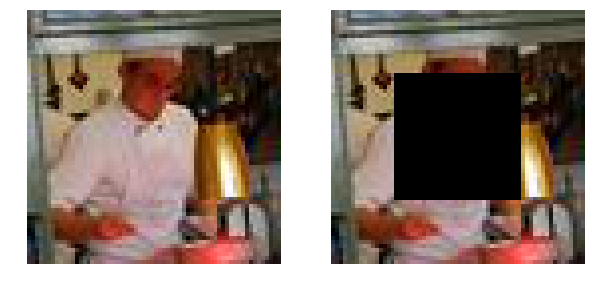

In [7]:
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1, 2, 1)
plt.imshow(iterator.train_images[14].numpy().transpose(1, 2, 0))
plt.axis('off')
fig.add_subplot(1, 2, 2)
plt.imshow(iterator.noisy_train_images[14].numpy().transpose(1, 2, 0))
plt.axis('off')

In [8]:
class UNetGenerator(nn.Module):
    """Generator module."""

    def __init__(self, start_filter):
        """Initialize generator."""
        super(UNetGenerator, self).__init__()

        #################################
        ####### DOWNSAMPLER MODULE ######
        #################################

        # 3 x 64 x 64
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=start_filter, kernel_size=4,
            stride=2, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(start_filter)

        # 16 x 32 x 32
        self.conv2 = nn.Conv2d(
            in_channels=start_filter, out_channels=start_filter * 2,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(start_filter * 2)

        # 32 x 16 x 16
        self.conv3 = nn.Conv2d(
            in_channels=start_filter * 2, out_channels=start_filter * 3,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(start_filter * 3)

        # 64 x 8 x 8
        self.conv4 = nn.Conv2d(
            in_channels=start_filter * 3, out_channels=start_filter * 4,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn4 = nn.BatchNorm2d(start_filter * 4)

        #################################
        ####### UPSAMPLER MODULE ########
        #################################

        # 128 x 4 x 4
        self.tconv1 = nn.ConvTranspose2d(
            in_channels=start_filter * 4, out_channels=start_filter * 3,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.tbn1 = nn.BatchNorm2d(start_filter * 3)

        # 64 x 8 x 8
        self.tconv2 = nn.ConvTranspose2d(
            in_channels=start_filter * 3, out_channels=start_filter * 2,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.tbn2 = nn.BatchNorm2d(start_filter * 2)

        # 32 x 16 x 16
        self.tconv3 = nn.ConvTranspose2d(
            in_channels=start_filter * 2, out_channels=start_filter,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.tbn3 = nn.BatchNorm2d(start_filter)

        # 16 x 32 x 32
        self.tconv4 = nn.ConvTranspose2d(
            in_channels=start_filter, out_channels=3,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        # Finally - 3 x 64 x 64

    def forward(self, input):
        """Propogate input through the generator."""
        # Downsampling steps.
        conv1 = F.relu(self.bn1(self.conv1(input)))
        conv2 = F.relu(self.bn2(self.conv2(conv1)))
        conv3 = F.relu(self.bn3(self.conv3(conv2)))
        conv4 = F.relu(self.bn4(self.conv4(conv3)))

        # Upsampling steps.
        tconv1 = F.relu(self.tbn1(self.tconv1(conv4)))
        tconv2 = F.relu(self.tbn2(self.tconv2(tconv1)))
        tconv3 = F.relu(self.tbn3(self.tconv3(tconv2)))
        tconv4 = F.tanh(self.tconv4(tconv3))

        return tconv4

In [9]:
class UNetGeneratorSkip(nn.Module):
    """Generator module."""

    def __init__(self, start_filter):
        """Initialize generator."""
        super(UNetGeneratorSkip, self).__init__()

        #################################
        ####### DOWNSAMPLER MODULE ######
        #################################

        # 3 x 64 x 64
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=start_filter, kernel_size=4,
            stride=2, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(start_filter)

        # 16 x 32 x 32
        self.conv2 = nn.Conv2d(
            in_channels=start_filter, out_channels=start_filter * 2,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(start_filter * 2)

        # 32 x 16 x 16
        self.conv3 = nn.Conv2d(
            in_channels=start_filter * 2, out_channels=start_filter * 3,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(start_filter * 3)

        # 48 x 8 x 8
        self.conv4 = nn.Conv2d(
            in_channels=start_filter * 3, out_channels=start_filter * 4,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn4 = nn.BatchNorm2d(start_filter * 4)

        #################################
        ####### UPSAMPLER MODULE ########
        #################################

        # 64 x 4 x 4
        self.tconv1 = nn.ConvTranspose2d(
            in_channels=start_filter * 4, out_channels=start_filter * 3,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.tbn1 = nn.BatchNorm2d(start_filter * 3)

        # 48 x 8 x 8 + 48 x 8 x 8 = [96 x 8 x 8]
        self.tconv2 = nn.ConvTranspose2d(
            in_channels=start_filter * 6, out_channels=start_filter * 2,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.tbn2 = nn.BatchNorm2d(start_filter * 2)

        # 32 x 16 x 16 + 32 x 16 x 16 = [64 x 16 x 16]
        self.tconv3 = nn.ConvTranspose2d(
            in_channels=start_filter * 4, out_channels=3,
            kernel_size=4, stride=2, padding=1, bias=False
        )

    def forward(self, input):
        """Propogate input through the generator."""
        # Downsampling steps.
        conv1 = F.relu(self.bn1(self.conv1(input)))
        conv2 = F.relu(self.bn2(self.conv2(conv1)))
        conv3 = F.relu(self.bn3(self.conv3(conv2)))
        conv4 = F.relu(self.bn4(self.conv4(conv3)))

        # Upsampling steps.
        tconv1 = F.relu(self.tbn1(self.tconv1(conv4)))
        tconv1 = torch.cat((tconv1, conv3), 1)

        tconv2 = F.relu(self.tbn2(self.tconv2(tconv1)))
        tconv2 = torch.cat((tconv2, conv2), 1)

        tconv3 = F.sigmoid(self.tconv3(tconv2))

        return tconv3

In [10]:
class Discriminator(nn.Module):
    """Discriminator."""

    def __init__(self, start_filter):
        """Initialize params."""
        super(Discriminator, self).__init__()

        # 3 x 32 x 32
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=start_filter, kernel_size=4,
            stride=2, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(start_filter)

        # 16 x 16 x 16
        self.conv2 = nn.Conv2d(
            in_channels=start_filter, out_channels=start_filter * 2,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(start_filter * 2)

        # 32 x 8 x 8
        self.conv3 = nn.Conv2d(
            in_channels=start_filter * 2, out_channels=start_filter * 3,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(start_filter * 3)

        # 48 x 4 x 4
        self.conv4 = nn.Conv2d(
            in_channels=start_filter * 3, out_channels=start_filter * 4,
            kernel_size=4, stride=1, padding=1, bias=False
        )
        self.bn4 = nn.BatchNorm2d(start_filter * 4)

        # 64 x 2 x 2
        self.conv5 = nn.Conv2d(
            in_channels=start_filter * 4, out_channels=1,
            kernel_size=2, stride=2, padding=0, bias=False
        )

    def forward(self, input):
        """Propogate input through the network."""
        # Downsampling steps.
        # print 'input', input.size()
        conv1 = F.leaky_relu(self.bn1(self.conv1(input)))
        conv2 = F.leaky_relu(self.bn2(self.conv2(conv1)))
        conv3 = F.leaky_relu(self.bn3(self.conv3(conv2)))
        conv4 = F.leaky_relu(self.bn4(self.conv4(conv3)))
        conv5 = self.conv5(conv4)

        return conv5.squeeze()

In [ ]:
generator = UNetGeneratorSkip(start_filter=32).cuda()
discriminator = Discriminator(start_filter=32).cuda()
optimizer_generator = optim.Adam(generator.parameters(), lr=1e-3, betas=(0.5, 0.999))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=1e-3, betas=(0.5, 0.999))
clamp_lower = -0.03
clamp_upper = 0.03
loss_criterion = nn.MSELoss().cuda()
save_dir = 'inpainting/samples'

In [20]:
def save_plots(epoch, fake_images, real_images, real_examples_full):
    j = np.random.randint(low=0, high=500)
    real_examples_full, real_examples, fake_images = iterator.get_valid_minibatch(j, 32)
    generator.eval()
    reconstructions = generator(fake_images)
    # fig = plt.figure(figsize=(20, 40))
    # idx = 1
    reconstructions = reconstructions.data.cpu().numpy()
    real = real_examples_full.data.cpu().numpy()
    real_copy = copy.deepcopy(real)
    real_copy[:, :, 16:48, 16:48] = reconstructions
    real_copy = torch.from_numpy(real_copy)
    real = torch.from_numpy(real)
    out_tensor = torch.zeros(1, real_copy.size(1), real_copy.size(2), real_copy.size(3))
    for zz, zzz in zip(real_copy[:10], real[:10]):
        out_tensor = torch.cat([out_tensor, zz.unsqueeze(0)])
        out_tensor = torch.cat([out_tensor, zzz.unsqueeze(0)])
    vutils.save_image(out_tensor[1:], 'samples_l2gan_disc5_nosigmoid/epoch_%d_samples.png' % (epoch), normalize=True, scale_each=True, nrow=4)
    generator.train()
    '''
    for reconstruction, real_ in zip(real_copy[:20], real[:20]):
        fig.add_subplot(5, 8, idx)
        plt.imshow(reconstruction.transpose(1, 2, 0))
        plt.axis('off')
        fig.add_subplot(5, 8, idx + 1)
        plt.imshow(real_.transpose(1, 2, 0))
        plt.axis('off')
        idx += 2
    plt.savefig('samples/epoch_%d_samples' % (epoch))
    '''

In [21]:
for i in xrange(1000):
    discriminator_losses = []
    generator_losses = []
    for j in xrange(0, iterator.num_train, 32):        
        ############################
        # (1) Update D network
        ############################
        
        for disc_updates in xrange(5):
            real_examples_full, real_examples, fake_images = iterator.get_train_minibatch(j, 32)
            D1 = discriminator(real_examples)
            fake = generator(fake_images)
            D2 = discriminator(fake)
            discriminator_loss = -.5 * ((D1 - D2).mean())
            optimizer_discriminator.zero_grad()
            discriminator_loss.backward()
            optimizer_discriminator.step()

            discriminator_losses.append(discriminator_loss.data[0])

            # clamp parameters to a cube
            for p in discriminator.parameters():
                p.data.clamp_(clamp_lower, clamp_upper)
        
        ############################
        # (2) Update G network
        ############################
        
        generated_images = generator(fake_images)
        generator_loss = -.5 * discriminator(
            generated_images
        ).mean() + loss_criterion(generated_images, real_examples)
        optimizer_generator.zero_grad()
        generator_loss.backward()
        optimizer_generator.step()
        generator_losses.append(generator_loss.data[0])

    print '[%d] Loss_D: %f Loss_G: %f' % (i, np.mean(discriminator_losses), np.mean(generator_losses))
    save_plots(i, fake_images, real_examples, real_examples_full)

[0] Loss_D: -0.487614 Loss_G: 0.307643
[1] Loss_D: -0.476870 Loss_G: 0.309559
[2] Loss_D: -0.477780 Loss_G: 0.308289
[3] Loss_D: -0.467901 Loss_G: 0.300584
[4] Loss_D: -0.478399 Loss_G: 0.315664
[5] Loss_D: -0.478209 Loss_G: 0.307838
[6] Loss_D: -0.472815 Loss_G: 0.311679
[7] Loss_D: -0.478017 Loss_G: 0.312507
[8] Loss_D: -0.479820 Loss_G: 0.314292
[9] Loss_D: -0.478566 Loss_G: 0.318872
[10] Loss_D: -0.476710 Loss_G: 0.311163
[11] Loss_D: -0.480016 Loss_G: 0.320405
[12] Loss_D: -0.480619 Loss_G: 0.319986
[13] Loss_D: -0.477348 Loss_G: 0.320882
[14] Loss_D: -0.462373 Loss_G: 0.308463
[15] Loss_D: -0.466235 Loss_G: 0.316779
[16] Loss_D: -0.471252 Loss_G: 0.321106
[17] Loss_D: -0.470771 Loss_G: 0.320961
[18] Loss_D: -0.466326 Loss_G: 0.320700
[19] Loss_D: -0.464076 Loss_G: 0.316163
[20] Loss_D: -0.469070 Loss_G: 0.316040
[21] Loss_D: -0.455315 Loss_G: 0.314709
[22] Loss_D: -0.452454 Loss_G: 0.309370
[23] Loss_D: -0.465850 Loss_G: 0.320054
[24] Loss_D: -0.455643 Loss_G: 0.317243
[25] Loss_

KeyboardInterrupt: 

In [76]:
save_plots(i, fake_images, real_examples, real_examples_full)

In [ ]:
torch.stack()

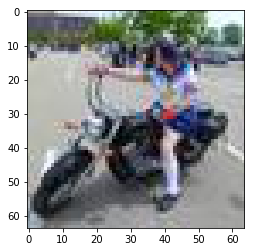

In [16]:
plt.imshow(real_examples[25].data.cpu().numpy().transpose(1, 2, 0))

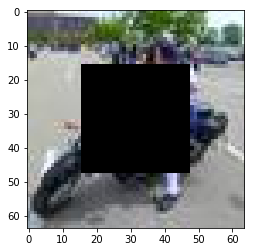

In [17]:
plt.imshow(fake_images[25].data.cpu().numpy().transpose(1, 2, 0))

In [ ]:
x = np.random.rand(10, 3, 64, 64)
y = np